In [1]:
!pip install tqdm
!pip install albumentations==1.3.0 opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 683.6 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 3.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 2.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 2.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 1.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 2.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 1.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.4/315.4 kB 2.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 2.6 MB/s eta 0:00:0000:0100:01
   

In [ ]:
import os
import numpy as np
from PIL import Image
import cv2
import albumentations as A
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from simclip_utils import is_photo, make_mosaic

# 为每个增广transform加入additional_targets参数
transform_1 = A.Compose([
    A.RandomResizedCrop(height=224, width=224, scale=(0.8,1.0), p=1),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05, p=0.5),
    A.RandomGamma(gamma_limit=(80,120), p=0.5),
    A.Solarize(threshold=128, p=0.3),
    A.ChannelShuffle(p=0.2),
    A.GaussianBlur(blur_limit=(3,7), p=0.3),
    A.JpegCompression(quality_lower=50, quality_upper=100, p=0.3),
    A.Resize(224,224),
], additional_targets={'image2': 'image'})

transform_2 = A.Compose([
    A.RandomResizedCrop(height=224, width=224, scale=(0.8,1.0), p=1),
    A.Rotate(limit=20, p=0.5),
    A.Crop(x_min=0, y_min=0, x_max=224, y_max=112, p=1),
    A.Resize(224,224),
    A.InvertImg(p=0.2),
    A.Sharpen(alpha=(0.2,0.5), p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5)
], additional_targets={'image2': 'image'})

transform_3 = A.Compose([
    A.RandomResizedCrop(height=224, width=224, scale=(0.8,1.0), p=1),
    A.HorizontalFlip(p=0.5),
    A.Crop(x_min=0, y_min=112, x_max=224, y_max=224, p=1),
    A.Resize(224,224),
    A.RandomGamma(gamma_limit=(80,120), p=0.5),
    A.OpticalDistortion(distort_limit=0.2, shift_limit=0.1, p=0.5),
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1, p=0.5),
    A.GaussianBlur(blur_limit=(3,7), p=0.3),
], additional_targets={'image2': 'image'})

transform_4 = A.Compose([
    A.RandomResizedCrop(height=224, width=224, scale=(0.8,1.0), p=1),
    A.Rotate(limit=15, p=0.5),
    A.Crop(x_min=0, y_min=56, x_max=224, y_max=168, p=1),
    A.Resize(224,224),
    A.Cutout(num_holes=1, max_h_size=30, max_w_size=30, fill_value=0, p=0.5),
    A.Solarize(threshold=128, p=0.3),
    A.JpegCompression(quality_lower=30, quality_upper=100, p=0.3),
    A.ChannelShuffle(p=0.2),
], additional_targets={'image2': 'image'})


basic_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
])

def make_mosaic(images):
    row1 = np.hstack([images[0], images[1]])
    row2 = np.hstack([images[2], images[3]])
    mosaic = np.vstack([row1, row2])
    return mosaic

class MultiModalLandmarksQuadAugDataset(Dataset):
    def __init__(self, rgb_root, landmarks_root):
        self.rgb_dataset = datasets.ImageFolder(root=rgb_root, is_valid_file=is_photo)
        self.depth_dataset = datasets.ImageFolder(root=landmarks_root, is_valid_file=is_photo)

        print("RGB 数据集长度:", len(self.rgb_dataset))
        print("Landmarks 数据集长度:", len(self.depth_dataset))
        
        self.synchronize_datasets()
        
        self.aug_list = [transform_1, transform_2, transform_3, transform_4]

    def synchronize_datasets(self):
        def get_relative_paths(dataset, is_depth=False):
            relative_paths = []
            for path, _ in dataset.samples:
                rel_path = os.path.relpath(path, dataset.root)
                if is_depth:
                    dir_name, file_name = os.path.split(rel_path)
                    base_name = file_name.replace('_landmarks', '')
                    rel_path = os.path.join(dir_name, base_name)
                relative_paths.append(rel_path)
            return relative_paths
        
        rgb_paths = get_relative_paths(self.rgb_dataset)
        depth_paths = get_relative_paths(self.depth_dataset, is_depth=True)
        
        common_paths = set(rgb_paths) & set(depth_paths)
        
        def filter_dataset(dataset, common_paths, is_depth=False):
            new_samples = []
            for path, label in dataset.samples:
                rel_path = os.path.relpath(path, dataset.root)
                if is_depth:
                    dir_name, file_name = os.path.split(rel_path)
                    base_name = file_name.replace('_landmarks', '')
                    rel_path_processed = os.path.join(dir_name, base_name)
                else:
                    rel_path_processed = rel_path
                if rel_path_processed in common_paths:
                    new_samples.append((path, label))
            dataset.samples = new_samples
            dataset.targets = [s[1] for s in new_samples]
        
        filter_dataset(self.rgb_dataset, common_paths)
        filter_dataset(self.depth_dataset, common_paths, is_depth=True)
        
        self.dataset_length = len(self.rgb_dataset)
        print("同步后的数据集长度:", self.dataset_length)

    def __len__(self):
        return self.dataset_length

    def __getitem__(self, idx):
        rgb_path, label = self.rgb_dataset.samples[idx]
        landmarks_path, label_l = self.depth_dataset.samples[idx]
        assert label == label_l, "RGB和Landmarks的标签不一致"
        
        # 加载原始图像
        rgb_image_pil = Image.open(rgb_path).convert('RGB')
        landmarks_image_pil = Image.open(landmarks_path).convert('RGB') 

        # 转为numpy用于Albumentations
        rgb_np = np.array(rgb_image_pil)
        landmarks_np = np.array(landmarks_image_pil)

        # 对同一对图像应用四种不同增强
        rgb_augs = []
        landmarks_augs = []
        for aug in self.aug_list:
            out = aug(image=rgb_np, image2=landmarks_np)
            rgb_augs.append(out['image'])
            landmarks_augs.append(out['image2'])

        # 将四个增强后的图像拼接成2x2马赛克
        rgb_mosaic = make_mosaic(rgb_augs)
        landmarks_mosaic = make_mosaic(landmarks_augs)

        # 缩放回224x224
        rgb_mosaic = cv2.resize(rgb_mosaic, (224,224), interpolation=cv2.INTER_LINEAR)
        landmarks_mosaic = cv2.resize(landmarks_mosaic, (224,224), interpolation=cv2.INTER_LINEAR)

        # 转为Tensor
        rgb_mosaic_tensor = transforms.ToTensor()(Image.fromarray(rgb_mosaic))
        landmarks_mosaic_tensor = transforms.ToTensor()(Image.fromarray(landmarks_mosaic))

        # 基本版本（无增强）的图像
        rgb_basic = basic_transform(rgb_image_pil)
        landmarks_basic = basic_transform(landmarks_image_pil)

        return rgb_basic, rgb_mosaic_tensor, landmarks_basic, landmarks_mosaic_tensor, label


if __name__ == "__main__":
    rgb_root='/workspace/2470_Final/affectnet/AffectNet/train'
    landmarks_root='/workspace/2470_Final/affectnet/AffectNet_landmarks/train'

    dataset = MultiModalLandmarksQuadAugDataset(rgb_root, landmarks_root)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

    for rgb_basic, rgb_mosaic, landmarks_basic, landmarks_mosaic, label in dataloader:
        print("RGB基本版:", rgb_basic.shape)
        print("RGB 4x增强马赛克:", rgb_mosaic.shape)
        print("Landmarks基本版:", landmarks_basic.shape)
        print("Landmarks 4x增强马赛克:", landmarks_mosaic.shape)
        print("标签:", label)
        break

/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:316: FutureWarning: JpegCompression has been deprecated. Please use ImageCompression
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


RGB 数据集长度: 37555
Landmarks 数据集长度: 37396
同步后的数据集长度: 37396
RGB基本版: torch.Size([4, 3, 224, 224])
RGB 4x增强马赛克: torch.Size([4, 3, 224, 224])
Landmarks基本版: torch.Size([4, 3, 224, 224])
Landmarks 4x增强马赛克: torch.Size([4, 3, 224, 224])
标签: tensor([7, 6, 6, 1])


In [3]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.2/165.2 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 29.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 36.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 65.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


RGB 数据集长度: 37555
Landmarks 数据集长度: 37396
同步后的数据集长度: 37396
RGB基本版: torch.Size([4, 3, 224, 224])
RGB 4x增强马赛克: torch.Size([4, 3, 224, 224])
Landmarks基本版: torch.Size([4, 3, 224, 224])
Landmarks 4x增强马赛克: torch.Size([4, 3, 224, 224])
标签: tensor([4, 0, 5, 0])


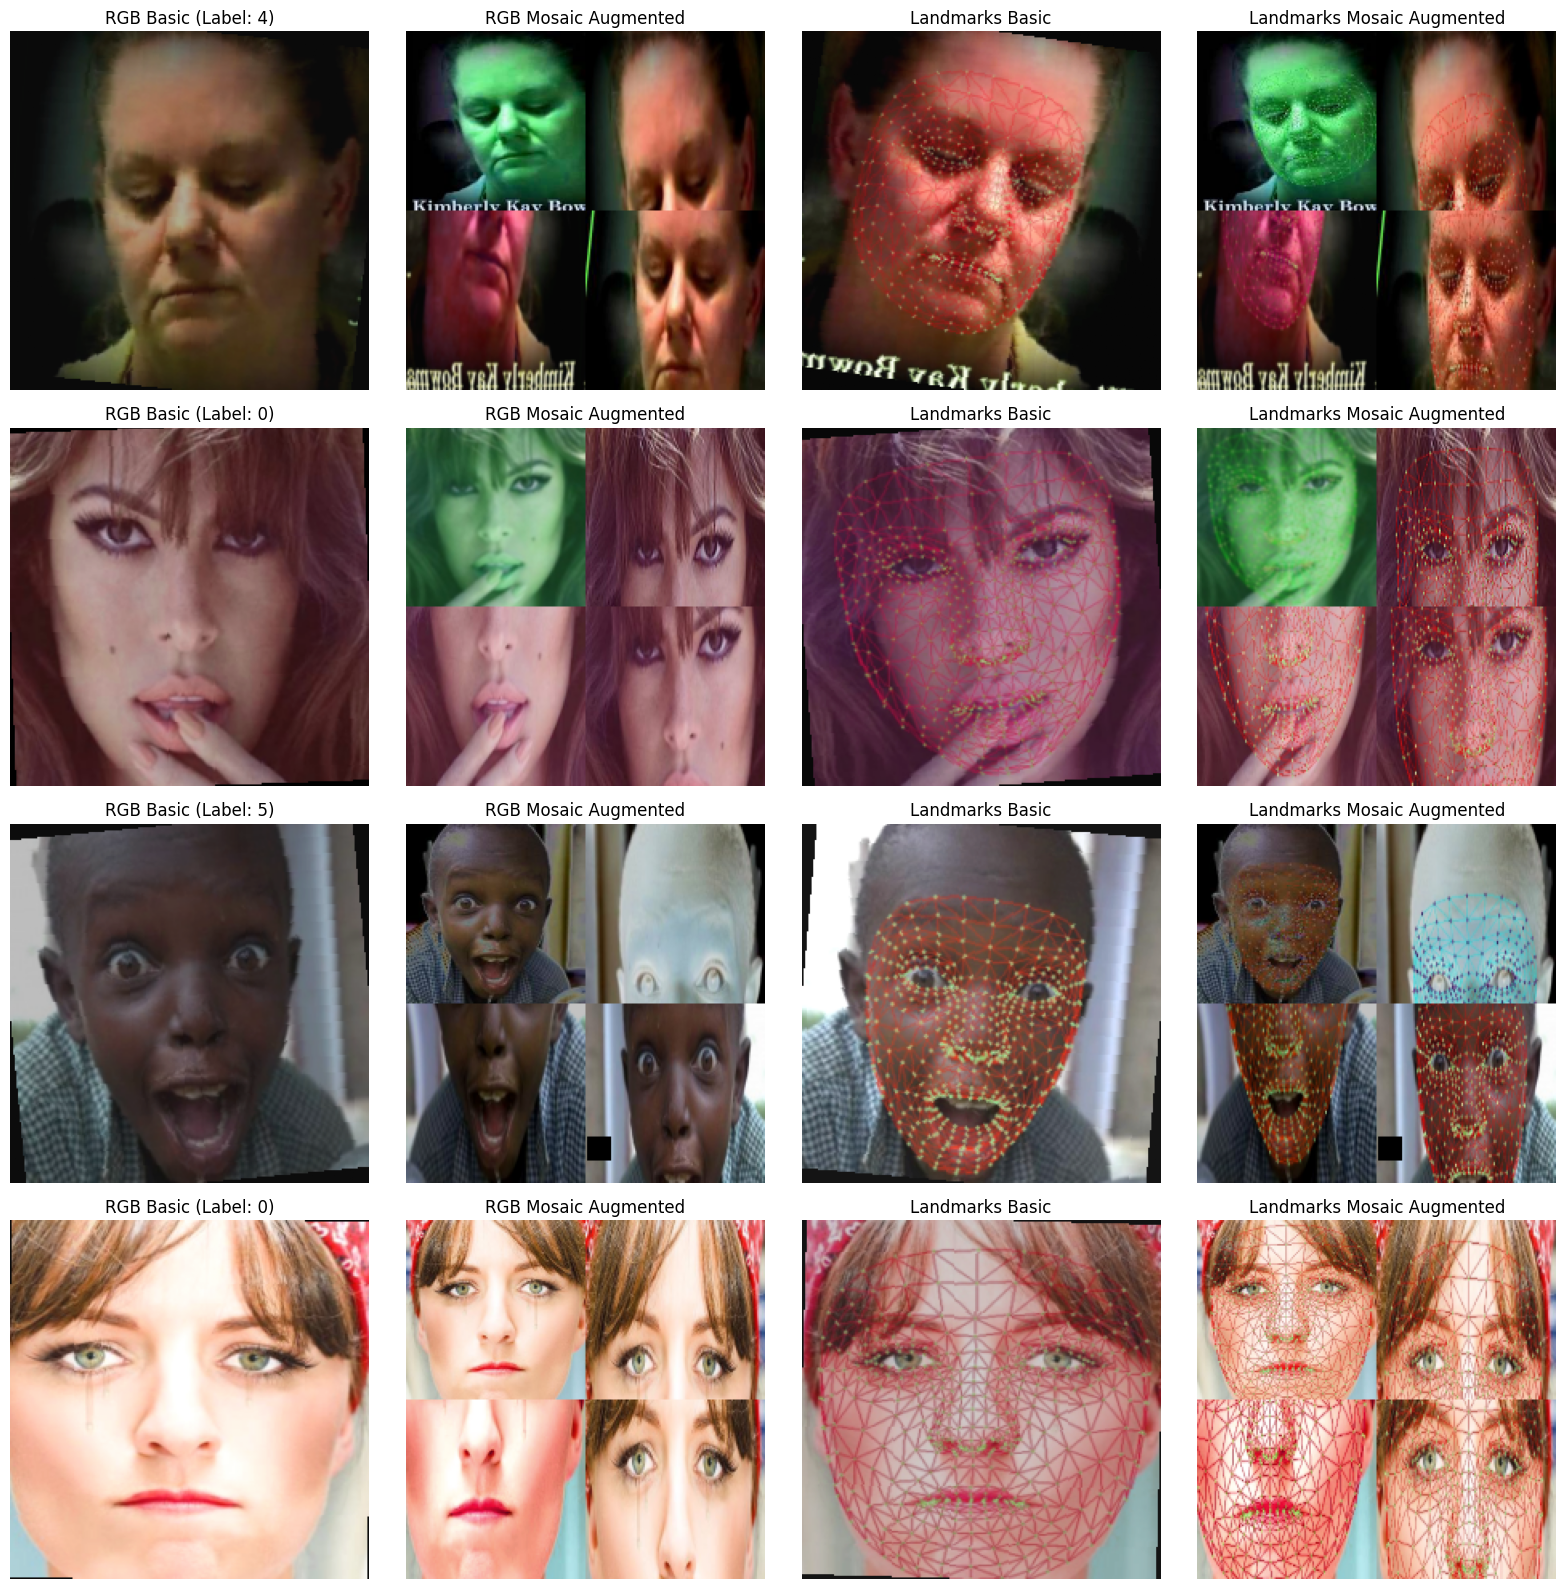

In [4]:
import matplotlib.pyplot as plt

if __name__ == "__main__":
    rgb_root = '/workspace/2470_Final/affectnet/AffectNet/train'
    landmarks_root = '/workspace/2470_Final/affectnet/AffectNet_landmarks/train'

    dataset = MultiModalLandmarksQuadAugDataset(rgb_root, landmarks_root)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

    # 取一个批次的数据
    rgb_basic, rgb_mosaic, landmarks_basic, landmarks_mosaic, label = next(iter(dataloader))

    print("RGB基本版:", rgb_basic.shape)        # [B, C, H, W]
    print("RGB 4x增强马赛克:", rgb_mosaic.shape)  # [B, C, H, W]
    print("Landmarks基本版:", landmarks_basic.shape)  # [B, C, H, W]
    print("Landmarks 4x增强马赛克:", landmarks_mosaic.shape)  # [B, C, H, W]
    print("标签:", label)

    # 可视化前4个样本
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    for i in range(4):  # 前四个样本
        # RGB 基本版
        img_rgb_basic = rgb_basic[i].permute(1, 2, 0).cpu().numpy()  # 转换通道顺序
        axes[i, 0].imshow(img_rgb_basic)
        axes[i, 0].set_title(f"RGB Basic (Label: {label[i].item()})")
        axes[i, 0].axis('off')

        # RGB 增强马赛克
        img_rgb_mosaic = rgb_mosaic[i].permute(1, 2, 0).cpu().numpy()
        axes[i, 1].imshow(img_rgb_mosaic)
        axes[i, 1].set_title("RGB Mosaic Augmented")
        axes[i, 1].axis('off')

        # Landmarks 基本版
        img_landmarks_basic = landmarks_basic[i].permute(1, 2, 0).cpu().numpy()
        axes[i, 2].imshow(img_landmarks_basic)
        axes[i, 2].set_title("Landmarks Basic")
        axes[i, 2].axis('off')

        # Landmarks 增强马赛克
        img_landmarks_mosaic = landmarks_mosaic[i].permute(1, 2, 0).cpu().numpy()
        axes[i, 3].imshow(img_landmarks_mosaic)
        axes[i, 3].set_title("Landmarks Mosaic Augmented")
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

In [25]:
rgb_root='/workspace/2470_Final/affectnet/AffectNet/train'
landmarks_root='/workspace/2470_Final/affectnet/AffectNet_landmarks/train'

dataset = MultiModalLandmarksQuadAugDataset(rgb_root, landmarks_root)
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

RGB 数据集长度: 37555
Landmarks 数据集长度: 37396
同步后的数据集长度: 37396


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from tqdm import tqdm
import os
from pathlib import Path
import cv2
import albumentations as A
import numpy as np
# import matplotlib.pyplot as plt

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResNetFeatureExtractor(nn.Module):
    def __init__(self, input_channels):
        super(ResNetFeatureExtractor, self).__init__()
        if input_channels == 3:
            self.resnet = models.resnet50(pretrained=True)
        else:
            self.resnet = models.resnet50(pretrained=True)
            self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])  # 移除最后的全连接层
        self.fc = nn.Linear(2048, 256)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Define two networks for RGB and depth images
rgb_net = ResNetFeatureExtractor(input_channels=3).to(device)
depth_net = ResNetFeatureExtractor(input_channels=3).to(device)

class ProjectionHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ProjectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc2 = nn.Linear(input_dim, input_dim)
        self.bn2 = nn.BatchNorm1d(input_dim)
        self.fc3 = nn.Linear(input_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

projection_rgb = ProjectionHead(256, 128).to(device)
projection_depth = ProjectionHead(256, 128).to(device)


def contrastive_loss(features1, features2):
    features1 = F.normalize(features1, p=2, dim=1)
    features2 = F.normalize(features2, p=2, dim=1)
    logits = torch.matmul(features1, features2.T)
    labels = torch.arange(features1.size(0)).to(features1.device)
    loss = F.cross_entropy(logits, labels)
    return loss

def nt_xent_loss(features1, features2, temperature=0.5):
    features1 = F.normalize(features1, p=2, dim=1)
    features2 = F.normalize(features2, p=2, dim=1)
    features = torch.cat([features1, features2], dim=0)
    similarity_matrix = torch.matmul(features, features.T) / temperature
    batch_size = features1.size(0)
    labels = torch.arange(batch_size).to(features1.device)
    labels = torch.cat([labels, labels], dim=0)
    mask = torch.eye(2 * batch_size, dtype=bool).to(features1.device)
    similarity_matrix = similarity_matrix.masked_fill(mask, -float('inf'))
    positives = torch.cat([torch.diag(similarity_matrix, batch_size), torch.diag(similarity_matrix, -batch_size)])
    negatives = similarity_matrix[~mask].view(2 * batch_size, -1)
    logits = torch.cat([positives.unsqueeze(1), negatives], dim=1)
    labels = torch.zeros(2 * batch_size, dtype=torch.long).to(features1.device)
    loss = F.cross_entropy(logits, labels)
    return loss


lambda_recon = 1.0
optimizer = optim.Adam([
    {'params': rgb_net.parameters()},
    {'params': depth_net.parameters()},
    {'params': projection_rgb.parameters()},
    {'params': projection_depth.parameters()},
], lr=1e-4)

criterion_reconstruction = nn.MSELoss()

# 后续训练流程保持不变
# ...

In [7]:
from torch.utils.data import Dataset
import os
from PIL import Image
import torchvision.datasets as datasets
from torchvision import transforms


class MultiModalDataset_Test_Single(Dataset):
    def __init__(self, rgb_root, transform_rgb=None, transform_gray=None):
        # 使用单个数据集目录
        self.rgb_dataset = datasets.ImageFolder(root=rgb_root)

        # 用户提供的transform，用于后续处理
        self.transform_rgb = transform_rgb
        self.transform_gray = transform_gray

        print("RGB数据集长度:", len(self.rgb_dataset))
        
        # 数据集长度
        self.dataset_length = len(self.rgb_dataset)
        print("数据集长度:", self.dataset_length)

    def __len__(self):
        return self.dataset_length

    def __getitem__(self, idx):
        # 从RGB数据集中获取图像和标签
        img_path, label = self.rgb_dataset.samples[idx]
        
        # 打开图像（RGB格式）
        image_pil = Image.open(img_path).convert('RGB')

        # 对RGB图像应用transform_rgb
        if self.transform_rgb is not None:
            rgb_image = self.transform_rgb(image_pil)
        else:
            # 如果未指定transform_rgb，则默认转换为Tensor
            from torchvision import transforms
            rgb_image = transforms.ToTensor()(image_pil)

        # 对同一张图像应用transform_gray，用于生成灰度版
        if self.transform_gray is not None:
            gray_image = self.transform_gray(image_pil)
        else:
            # 如果未指定transform_gray，则简单转换为灰度后ToTensor
            from torchvision import transforms
            gray_transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor()
            ])
            gray_image = gray_transform(image_pil)
        
        # 返回RGB图像、灰度图像和标签
        return rgb_image, gray_image, label

# 定义RGB和灰度transform
transform_rgb = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

transform_gray = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

rgb_root = "/workspace/2470_Final/affectnet/AffectNet/test"
test_dataset = MultiModalDataset_Test_Single(rgb_root, transform_rgb=transform_rgb, transform_gray=transform_gray)

RGB数据集长度: 3201
数据集长度: 3201


In [8]:
multi_modal_loader_test = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

In [7]:
checkpoint = torch.load(f'contrastive_learning_model_epoch_{8}.pth')
rgb_net.load_state_dict(checkpoint['rgb_net_state_dict'])
depth_net.load_state_dict(checkpoint['depth_net_state_dict'])
projection_rgb.load_state_dict(checkpoint['projection_rgb_state_dict'])
projection_depth.load_state_dict(checkpoint['projection_depth_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# rgb_decoder.load_state_dict(checkpoint['rgb_decoder_state_dict'])
# depth_decoder.load_state_dict(checkpoint['depth_decoder_state_dict'])
print(f'Model from epoch loaded successfully.')

Model from epoch loaded successfully.


In [ ]:
# Training
rgb_net.train()
depth_net.train()
projection_rgb.train()
projection_depth.train()

epochs = 21

for epoch in range(epochs):
    epoch_loss = 0
    for rgb_images, rgb_augmented_images, depth_images, depth_augmented_images, labelq in tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{epochs}]"):
        # Move data to GPU
        rgb_images = rgb_images.to(device)
        rgb_augmented_images = rgb_augmented_images.to(device)
        depth_images = depth_images.to(device)
        depth_augmented_images = depth_augmented_images.to(device)

        # Contrastive learning with augmented images (RGB)
        rgb_features_1 = rgb_net(rgb_augmented_images)
        rgb_features_2 = rgb_net(rgb_images)
        rgb_projection_1 = projection_rgb(rgb_features_1)
        rgb_projection_2 = projection_rgb(rgb_features_2)
        loss_rgb = nt_xent_loss(rgb_features_1, rgb_features_2)

        # Contrastive learning with augmented images (Depth)
        depth_features_1 = depth_net(depth_augmented_images)
        depth_features_2 = depth_net(depth_images)
        depth_projection_1 = projection_depth(depth_features_1)
        depth_projection_2 = projection_depth(depth_features_2)
        loss_depth = nt_xent_loss(depth_features_1, depth_features_2)

        # Aligning RGB and depth images through contrastive learning
        rgb_features = rgb_net(rgb_images)
        depth_features = depth_net(depth_images)
        rgb_projection = projection_rgb(rgb_features)
        depth_projection = projection_depth(depth_features)
        loss_rgb_depth = contrastive_loss(rgb_projection, depth_projection)

        loss_rgb_depth_aug = contrastive_loss(rgb_projection_1, depth_projection_1)

        loss = loss_rgb + loss_depth + loss_rgb_depth + loss_rgb_depth_aug
        epoch_loss += loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {epoch_loss / len(train_dataloader)}')

    if epoch % 4 == 0 and epoch != 0:
        # Save the model
        torch.save({
            'rgb_net_state_dict': rgb_net.state_dict(),
            'depth_net_state_dict': depth_net.state_dict(),
            'projection_rgb_state_dict': projection_rgb.state_dict(),
            'projection_depth_state_dict': projection_depth.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, f'contrastive_learning_model_epoch_{epoch}.pth')


Epoch [1/21]: 100%|██████████| 1169/1169 [05:24<00:00,  3.60it/s]


Epoch [1/21], Average Loss: 10.247572521147715


Epoch [2/21]: 100%|██████████| 1169/1169 [05:24<00:00,  3.60it/s]


Epoch [2/21], Average Loss: 9.925542450440654


Epoch [3/21]: 100%|██████████| 1169/1169 [05:24<00:00,  3.60it/s]


Epoch [3/21], Average Loss: 9.860907154066936


Epoch [4/21]: 100%|██████████| 1169/1169 [05:25<00:00,  3.59it/s]


Epoch [4/21], Average Loss: 9.825701413346316


Epoch [5/21]: 100%|██████████| 1169/1169 [05:25<00:00,  3.59it/s]


Epoch [5/21], Average Loss: 9.801957444516484


Epoch [6/21]: 100%|██████████| 1169/1169 [05:25<00:00,  3.59it/s]


Epoch [6/21], Average Loss: 9.78506166818715


Epoch [7/21]: 100%|██████████| 1169/1169 [05:25<00:00,  3.59it/s]


Epoch [7/21], Average Loss: 9.769241660960828


Epoch [8/21]: 100%|██████████| 1169/1169 [05:25<00:00,  3.59it/s]


Epoch [8/21], Average Loss: 9.759550074617305


Epoch [9/21]: 100%|██████████| 1169/1169 [05:25<00:00,  3.59it/s]


Epoch [9/21], Average Loss: 9.74950491902765


Epoch [10/21]: 100%|██████████| 1169/1169 [05:25<00:00,  3.59it/s]


Epoch [10/21], Average Loss: 9.73981181325007


Epoch [11/21]: 100%|██████████| 1169/1169 [05:26<00:00,  3.58it/s]


Epoch [11/21], Average Loss: 9.733000727572739


Epoch [12/21]: 100%|██████████| 1169/1169 [05:25<00:00,  3.59it/s]


Epoch [12/21], Average Loss: 9.725723198074066


Epoch [13/21]: 100%|██████████| 1169/1169 [05:26<00:00,  3.58it/s]


Epoch [13/21], Average Loss: 9.721254378531711


Epoch [14/21]: 100%|██████████| 1169/1169 [05:26<00:00,  3.58it/s]


Epoch [14/21], Average Loss: 9.715725798398843


Epoch [15/21]: 100%|██████████| 1169/1169 [05:25<00:00,  3.59it/s]


Epoch [15/21], Average Loss: 9.711339506764407


Epoch [16/21]: 100%|██████████| 1169/1169 [05:26<00:00,  3.59it/s]


Epoch [16/21], Average Loss: 9.707231474289841


Epoch [17/21]: 100%|██████████| 1169/1169 [05:26<00:00,  3.58it/s]


Epoch [17/21], Average Loss: 9.704203643178817


Epoch [18/21]: 100%|██████████| 1169/1169 [05:25<00:00,  3.59it/s]


Epoch [18/21], Average Loss: 9.699987132902121


Epoch [19/21]: 100%|██████████| 1169/1169 [05:25<00:00,  3.60it/s]


Epoch [19/21], Average Loss: 9.695696337188382


Epoch [20/21]: 100%|██████████| 1169/1169 [05:25<00:00,  3.59it/s]


Epoch [20/21], Average Loss: 9.693096611212216


Epoch [21/21]:  80%|████████  | 938/1169 [04:21<01:04,  3.59it/s]

In [9]:
checkpoint = torch.load(f'contrastive_learning_model_epoch_{4}.pth')
rgb_net.load_state_dict(checkpoint['rgb_net_state_dict'])
depth_net.load_state_dict(checkpoint['depth_net_state_dict'])
projection_rgb.load_state_dict(checkpoint['projection_rgb_state_dict'])
projection_depth.load_state_dict(checkpoint['projection_depth_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# rgb_decoder.load_state_dict(checkpoint['rgb_decoder_state_dict'])
# depth_decoder.load_state_dict(checkpoint['depth_decoder_state_dict'])
print(f'Model from epoch loaded successfully.')

Model from epoch loaded successfully.


In [32]:
import os
import numpy as np
from PIL import Image
import cv2
import albumentations as A
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

def is_jpg(file_path):
    return file_path.lower().endswith('.jpg')

# 定义四个增强管线（针对RGB）
transform_1 = A.Compose([
    A.RandomResizedCrop(height=224, width=224, scale=(0.8,1.0), p=1),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05, p=0.5),
    A.RandomGamma(gamma_limit=(80,120), p=0.5),
    A.Solarize(threshold=128, p=0.3),
    A.ChannelShuffle(p=0.2),
    A.GaussianBlur(blur_limit=(3,7), p=0.3),
    A.JpegCompression(quality_lower=50, quality_upper=100, p=0.3),
    A.Resize(224,224),
])

transform_2 = A.Compose([
    A.RandomResizedCrop(height=224, width=224, scale=(0.8,1.0), p=1),
    A.Rotate(limit=20, p=0.5),
    A.Crop(x_min=0, y_min=0, x_max=224, y_max=112, p=1),
    A.Resize(224,224),
    A.InvertImg(p=0.2),
    A.Sharpen(alpha=(0.2,0.5), p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5)
])

transform_3 = A.Compose([
    A.RandomResizedCrop(height=224, width=224, scale=(0.8,1.0), p=1),
    A.HorizontalFlip(p=0.5),
    A.Crop(x_min=0, y_min=112, x_max=224, y_max=224, p=1),
    A.Resize(224,224),
    A.RandomGamma(gamma_limit=(80,120), p=0.5),
    A.OpticalDistortion(distort_limit=0.2, shift_limit=0.1, p=0.5),
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1, p=0.5),
    A.GaussianBlur(blur_limit=(3,7), p=0.3),
])

transform_4 = A.Compose([
    A.RandomResizedCrop(height=224, width=224, scale=(0.8,1.0), p=1),
    A.Rotate(limit=15, p=0.5),
    A.Crop(x_min=0, y_min=56, x_max=224, y_max=168, p=1),
    A.Resize(224,224),
    A.Cutout(num_holes=1, max_h_size=30, max_w_size=30, fill_value=0, p=0.5),
    A.Solarize(threshold=128, p=0.3),
    A.JpegCompression(quality_lower=30, quality_upper=100, p=0.3),
    A.ChannelShuffle(p=0.2),
])


# 基础转换(无增强)
basic_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 调整到较大尺寸
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),  # 随机裁剪到目标尺寸
    transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转
    transforms.RandomRotation(degrees=10),  # 随机旋转±10°
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),  # 随机亮度、对比度等
    transforms.ToTensor(),  # 转为张量
])

def make_mosaic(images):
    # images为4张增广后的图像(np.array格式, shape为(H,W,C))
    row1 = np.hstack([images[0], images[1]])
    row2 = np.hstack([images[2], images[3]])
    mosaic = np.vstack([row1, row2])
    return mosaic

class MultiModalLandmarksQuadAugDatasetTest(Dataset):
    def __init__(self, rgb_root, landmarks_root):
        self.rgb_dataset = datasets.ImageFolder(root=rgb_root, is_valid_file=is_jpg)
        self.depth_dataset = datasets.ImageFolder(root=landmarks_root, is_valid_file=is_jpg)

        print("RGB 数据集长度:", len(self.rgb_dataset))
        print("Landmarks 数据集长度:", len(self.depth_dataset))
        
        self.synchronize_datasets()
        
        # 定义增广列表
        self.aug_list = [transform_1, transform_2, transform_3, transform_4]

    def synchronize_datasets(self):
        def get_relative_paths(dataset, is_depth=False):
            relative_paths = []
            for path, _ in dataset.samples:
                rel_path = os.path.relpath(path, dataset.root)
                if is_depth:
                    dir_name, file_name = os.path.split(rel_path)
                    base_name = file_name.replace('_landmarks', '')
                    rel_path = os.path.join(dir_name, base_name)
                relative_paths.append(rel_path)
            return relative_paths
        
        rgb_paths = get_relative_paths(self.rgb_dataset)
        depth_paths = get_relative_paths(self.depth_dataset, is_depth=True)
        
        common_paths = set(rgb_paths) & set(depth_paths)
        
        def filter_dataset(dataset, common_paths, is_depth=False):
            new_samples = []
            for path, label in dataset.samples:
                rel_path = os.path.relpath(path, dataset.root)
                if is_depth:
                    dir_name, file_name = os.path.split(rel_path)
                    base_name = file_name.replace('_landmarks', '')
                    rel_path_processed = os.path.join(dir_name, base_name)
                else:
                    rel_path_processed = rel_path
                if rel_path_processed in common_paths:
                    new_samples.append((path, label))
            dataset.samples = new_samples
            dataset.targets = [s[1] for s in new_samples]
        
        filter_dataset(self.rgb_dataset, common_paths)
        filter_dataset(self.depth_dataset, common_paths, is_depth=True)
        
        self.dataset_length = len(self.rgb_dataset)
        print("同步后的数据集长度:", self.dataset_length)

    
    def __len__(self):
        return self.dataset_length

    def __getitem__(self, idx):
        rgb_path, label = self.rgb_dataset.samples[idx]
        landmarks_path, label_l = self.depth_dataset.samples[idx]
        assert label == label_l, "RGB和Landmarks的标签不一致"
        
        # 加载原始图像
        rgb_image_pil = Image.open(rgb_path).convert('RGB')
        landmarks_image_pil = Image.open(landmarks_path).convert('RGB') 

        # 转为numpy用于Albumentations
        rgb_np = np.array(rgb_image_pil)
        landmarks_np = np.array(landmarks_image_pil)

        # 对同一对图像应用四种不同增强
        rgb_augs = []
        landmarks_augs = []
        for aug in self.aug_list:
            out = aug(image=rgb_np, image2=landmarks_np)
            rgb_augs.append(out['image'])
            landmarks_augs.append(out['image2'])

        # 将四个增强后的图像拼接成2x2马赛克
        rgb_mosaic = make_mosaic(rgb_augs)
        landmarks_mosaic = make_mosaic(landmarks_augs)

        # 缩放回224x224
        rgb_mosaic = cv2.resize(rgb_mosaic, (224,224), interpolation=cv2.INTER_LINEAR)
        landmarks_mosaic = cv2.resize(landmarks_mosaic, (224,224), interpolation=cv2.INTER_LINEAR)


        # 转为Tensor
        rgb_mosaic_tensor = transforms.ToTensor()(Image.fromarray(rgb_mosaic))
        landmarks_mosaic_tensor = transforms.ToTensor()(Image.fromarray(landmarks_mosaic))

        # 基本版本（无增强）的图像
        rgb_basic = basic_transform(rgb_image_pil)
        landmarks_basic = basic_transform(landmarks_image_pil)

        return rgb_basic, rgb_mosaic_tensor, landmarks_basic, landmarks_mosaic_tensor, label


rgb_root='/workspace/2470_Final/affectnet/AffectNet/test'
landmarks_root='/workspace/2470_Final/affectnet/AffectNet_landmarks/test'

test_dataset = MultiModalLandmarksQuadAugDatasetTest(rgb_root, landmarks_root)
multi_modal_loader_test = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

RGB 数据集长度: 3201
Landmarks 数据集长度: 3216
同步后的数据集长度: 3190


In [33]:
# Finetune 阶段
print("Starting Finetune Phase...")
finetune_epochs = 12

# 定义设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classifier = nn.Sequential(
    nn.Linear(1280, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 8)  # 假设有8个类别
).to(device)

class Post_projectionHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Post_projectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc2 = nn.Linear(input_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

rgb_post = Post_projectionHead(512, 128)
depth_post = Post_projectionHead(512, 128)
rgb_post = rgb_post.to(device)
depth_post = depth_post.to(device)
    
# classifier = nn.Sequential(
#     nn.Linear(1280, 512),
#     nn.ReLU(),
#     nn.Linear(512, 8)  # 假设有8个类别
# ).to(device)

finetune_optimizer = optim.Adam(
    list(rgb_net.parameters()) +
    list(depth_net.parameters()) +
    list(classifier.parameters()) +
    list(projection_rgb.parameters())
    + list(projection_depth.parameters()),
    lr=1e-4
)


criterion = nn.CrossEntropyLoss()

for epoch in range(finetune_epochs):
    epoch_loss = 0
    for rgb_images, rgb_augmented_images, depth_images, depth_augmented_images, label_y in tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{finetune_epochs}]"):
        # 将数据移动到GPU
        rgb_images = rgb_images.to(device)
        depth_images = depth_images.to(device)
        rgb_augmented_images = rgb_augmented_images.to(device)
        depth_augmented_images = depth_augmented_images.to(device)
        label_y = label_y.to(device)

        # 提取投影特征并 concatenate
        rgb_features = rgb_net(rgb_images)
        rgb_features_aug = rgb_net(rgb_augmented_images)
        depth_features = depth_net(depth_images)
        depth_features_aug = depth_net(depth_augmented_images)
        rgb_features_2 = projection_rgb(rgb_features)
        rgb_features_2_aug = projection_rgb(rgb_features_aug)
        depth_features_2 = projection_depth(depth_features)
        depth_features_2_aug = projection_depth(depth_features_aug)



        combined_features = torch.cat((rgb_features_aug, rgb_features_2_aug, rgb_features, rgb_features_2, depth_features, depth_features_2, depth_features_2_aug), dim=1)

        # 通过分类器进行分类
        outputs = classifier(combined_features)

        cls_loss = criterion(outputs, label_y)
        # loss = cls_loss + recon_loss_rgb + recon_loss_depth
        loss = cls_loss
        epoch_loss = cls_loss.item()

        # 反向传播和优化
        finetune_optimizer.zero_grad()
        loss.backward()
        finetune_optimizer.step()
    print(f'Finetune Epoch [{epoch+1}/{finetune_epochs}], Average Loss: {epoch_loss / len(train_dataloader)}')

    # 测试集上的评估
    rgb_net.eval()
    depth_net.eval()
    classifier.eval()
    projection_rgb.eval()
    projection_depth.eval()
    rgb_post.eval()
    depth_post.eval()
    
    correct = 0
    total = 0

    with torch.no_grad():
        for rgb_images_test, rgb_augmented_test, depth_images_test, depth_augmented_test, label_y_test in tqdm(multi_modal_loader_test, desc=f"Epoch [{epoch+1}/{finetune_epochs}]"):
            # 将数据移动到GPU
            rgb_images_test = rgb_images_test.to(device)
            depth_images_test = depth_images_test.to(device)
            rgb_augmented_test = rgb_augmented_test.to(device)
            depth_augmented_test = depth_augmented_test.to(device)
            label_y_test = label_y_test.to(device)

            # 提取投影特征并 concatenate
            rgb_features = rgb_net(rgb_images_test)
            rgb_features_aug = rgb_net(rgb_augmented_test)
            depth_features = depth_net(depth_images_test)
            depth_features_aug = depth_net(depth_augmented_test)
            rgb_features_2 = projection_rgb(rgb_features)
            rgb_features_2_aug = projection_rgb(rgb_features_aug)
            depth_features_2 = projection_depth(depth_features)
            depth_features_2_aug = projection_depth(depth_features_aug)

            combined_features = torch.cat((rgb_features_aug, rgb_features_2_aug, rgb_features, rgb_features_2, depth_features, depth_features_2, depth_features_2_aug), dim=1)

            # 通过分类器进行分类
            outputs = classifier(combined_features)
            _, predicted = torch.max(outputs.data, 1)
            total += label_y_test.size(0)
            correct += (predicted == label_y_test).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy after Finetune Epoch [{epoch+1}/{finetune_epochs}]: {accuracy:.2f}%')

    rgb_net.train()
    depth_net.train()
    classifier.train()
    projection_rgb.train()
    projection_depth.train()

Starting Finetune Phase...


Epoch [1/12]: 100%|██████████| 1169/1169 [04:10<00:00,  4.66it/s]


Finetune Epoch [1/12], Average Loss: 0.0009634967947536498


Epoch [1/12]: 100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


Test Accuracy after Finetune Epoch [1/12]: 50.41%


Epoch [2/12]: 100%|██████████| 1169/1169 [03:56<00:00,  4.93it/s]


Finetune Epoch [2/12], Average Loss: 0.0008749054271609891


Epoch [2/12]: 100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


Test Accuracy after Finetune Epoch [2/12]: 52.88%


Epoch [3/12]: 100%|██████████| 1169/1169 [03:56<00:00,  4.95it/s]


Finetune Epoch [3/12], Average Loss: 0.0011911044475663105


Epoch [3/12]: 100%|██████████| 100/100 [00:23<00:00,  4.35it/s]


Test Accuracy after Finetune Epoch [3/12]: 53.45%


Epoch [4/12]: 100%|██████████| 1169/1169 [03:59<00:00,  4.88it/s]


Finetune Epoch [4/12], Average Loss: 0.0011400759373086451


Epoch [4/12]: 100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


Test Accuracy after Finetune Epoch [4/12]: 54.01%


Epoch [5/12]: 100%|██████████| 1169/1169 [03:57<00:00,  4.92it/s]


Finetune Epoch [5/12], Average Loss: 0.0008627169146509227


Epoch [5/12]: 100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


Test Accuracy after Finetune Epoch [5/12]: 56.43%


Epoch [6/12]: 100%|██████████| 1169/1169 [03:53<00:00,  5.01it/s]


Finetune Epoch [6/12], Average Loss: 0.0009461959475018817


Epoch [6/12]: 100%|██████████| 100/100 [00:21<00:00,  4.61it/s]


Test Accuracy after Finetune Epoch [6/12]: 56.39%


Epoch [7/12]: 100%|██████████| 1169/1169 [03:58<00:00,  4.91it/s]


Finetune Epoch [7/12], Average Loss: 0.0006219077762933344


Epoch [7/12]: 100%|██████████| 100/100 [00:22<00:00,  4.53it/s]


Test Accuracy after Finetune Epoch [7/12]: 55.64%


Epoch [8/12]: 100%|██████████| 1169/1169 [03:59<00:00,  4.88it/s]


Finetune Epoch [8/12], Average Loss: 0.0010079274940327562


Epoch [8/12]: 100%|██████████| 100/100 [00:21<00:00,  4.56it/s]


Test Accuracy after Finetune Epoch [8/12]: 56.11%


Epoch [9/12]: 100%|██████████| 1169/1169 [03:58<00:00,  4.89it/s]


Finetune Epoch [9/12], Average Loss: 0.0006501876563471133


Epoch [9/12]: 100%|██████████| 100/100 [00:21<00:00,  4.57it/s]


Test Accuracy after Finetune Epoch [9/12]: 54.39%


Epoch [10/12]:   6%|▌         | 68/1169 [00:14<03:57,  4.64it/s]


KeyboardInterrupt: 